# DBSCAN Clustering

A previous post covered clustering with the k-means algorithm. In this post, we consider a fundamentally different, density-based approach called DBSCAN. In contrast to k-means, which modeled clusters as sets of points near to their center, density-based approaches like DBSCAN model clusters as high-density clumps of points.

<img src='files/img/DBSCAN.png'>

## DBSCAN

DBSCAN, (Density-Based Spatial Clustering of Applications with Noise), captures the insight that clusters are dense groups of points. The idea is that if a particular point belongs to a cluster, it should be near to lots of other points in that cluster.

It works like this: First we choose two parameters, a positive number epsilon and a natural number minPoints. We then begin by picking an arbitrary point in our dataset. If there are more than minPoints points within a distance of epsilon from that point, (including the original point itself), we consider all of them to be part of a "cluster". We then expand that cluster by checking all of the new points and seeing if they too have more than minPoints points within a distance of epsilon, growing the cluster recursively if so.

Eventually, we run out of points to add to the cluster. We then pick a new arbitrary point and repeat the process. Now, it's entirely possible that a point we pick has fewer than minPoints points in its epsilon ball, and is also not a part of any other cluster. If that is the case, it's considered a "noise point" not belonging to any cluster.

(There's a slight complication worth pointing out: say minPoints=4, and you have a point with three points in its epsilon ball, including itself. Say the other two points belong to two different clusters, and each has 4 points in their epsilon balls. Then both of these dense points will "fight over" the original point, and it's arbitrary which of the two clusters it ends up in. Since DBSCAN considers the points in an arbitrary order, the middle point can end up in either the left or the right cluster on different runs. This kind of point is known as a "border point").

## Algorithm in Python

To fully understand the algorithm, I think it's best to just look at some code.

Below is a working implementation in Python. Note that the emphasis in this implementation is on illustrating the algorithm. The distance calculations, for example, could be optimized significantly.

In [1]:
import numpy as np

def MyDBSCAN(D, eps, MinPts):
    """
    Cluster the dataset `D` using the DBSCAN algorithm.
    
    MyDBSCAN takes a dataset `D` (a list of vectors), a threshold distance
    `eps`, and a required number of points `MinPts`.
    
    It will return a list of cluster labels. The label -1 means noise, and then
    the clusters are numbered starting from 1.
    """
    
    # This list will hold the final cluster assignment for each point in D.
    # There are two reserved values:
    #     -1 - Indicates a noise point
    #      0 - Means the point hasn't been considered yet
    # Initially all labels are 0.
    labels = [0] * len(D)
    
    # C is the ID of the current cluster.
    C = 0
    
    # This outer loop is just responsible for picking new seed points--a point
    # from which to grow a new cluster.
    # Once a valid seed point is found, a new cluster is created, and the
    # cluster growth is all handled by the 'expandCluster' routine.
    
    # For each point P in the Dataset D
    # ('P' is the index of the datapoint, rather than the datapoint itself.)
    for P in range(len(D)):
        
        # Only points that have not already been claimed can be picked as new
        # seed points.
        # If the point's label is not 0, continue to the next point.
        if labels[P] != 0:
            continue
            
        # Find all of P's neighboring points.
        NeighborPts = regionQuery(D, P, eps)
        
        # If the number is below MinPts, this point is noise.
        # This is the only condition under which a point is labeled
        # NOISE--when it's not a valid seed point. A NOISE point may later
        # be picked up by another cluster as a boundary point (this is the only
        # condition under which a cluster label can change--from NOISE to
        # something else).
        if len(NeighborPts) < MinPts:
            labels[P] = -1
        # Otherwise, if there are at least MinPts nearby, use this point as the
        # seed for a new cluster.
        else:
            C += 1
            growCluster(D, labels, P, NeighborPts, C, eps, MinPts)
            
    # All data has been clustered!
    return labels

def growCluster(D, labels, P, NeighborPts, C, eps, MinPts):
    """
    Grow a new cluster with label 'C' from the seed point 'P'.
    
    This function searches through the dataset to find all points that belong
    to this new cluster. When this function returns, cluster 'C' is complete.
    
    Parameters:
        'D'           - The dataset (a list of vectors)
        'labels'      - List storing the cluster labels for all dataset points
        'P'           - Index of the seed point for this new cluster
        'NeighborPts' - All of the neighbors of 'P'
        'C'           - The label for this new cluster.
        'eps'         - Threshold distance
        'MinPts'      - Minimum required number of neighbors
    """
    
    # Assign the cluster label to the seed point.
    labels[P] = C
    
    # Look at each neighbor of P (neighbors are referred to as Pn).
    # NeighborPts will be used as a FIFO queue of points to search--that is, it
    # will grow as we discover new branch points for the cluster. The FIFO
    # behavior is accomplished by using a while-loop rather than a for-loop.
    # In NeighborPts, the points are represented by their index in the original
    # dataset.
    i = 0
    while i < len(NeighborPts):
        
        # Get the next point from the queue
        Pn = NeighborPts[i]
        
        # If Pn was labelled NOISE during the seed search, then we
        # know it's not a branch point (it doesn't have enough neighbors), so
        # make it a leaf point of cluster C and move on.
        if labels[Pn] == -1:
            labels[Pn] = C
            
        # Otherwise, if Pn isn't already claimed, claim it as part of C.
        elif labels[Pn] == 0:
            # Add Pn to cluster C (Assign cluster label C).
            labels[Pn] = C
            
            # Find all the neighbors of Pn
            PnNeighborPts = regionQuery(D, Pn, eps)
            
            # If Pn has at least MinPts, neighbors, it's a branch point!
            # Add all of its neighbors to the FIFO queue to be searched.
            if len(PnNeighborPts) >= MinPts:
                NeighborPts += PnNeighborPts
                
        # Advance to the next point in the FIFO queue.
        i += 1
        
def regionQuery(D, P, eps):
    """
    Find all points in dataset 'D' within instance 'eps' of point 'P'
    
    This function calculates the distance between a point P and every other
    point in the dataset, and then returns only those points which are within a
    threshold distance 'eps'.
    """
    neighbors = []
    
    # For each point in the dataset
    for Pn in range(len(D)):
        
        # If the distance is below the threshold, add it to the neighbors list.
        if np.linalg.norm(D[P] - D[Pn]) < eps:
            neighbors.append(Pn)
            
    return neighbors

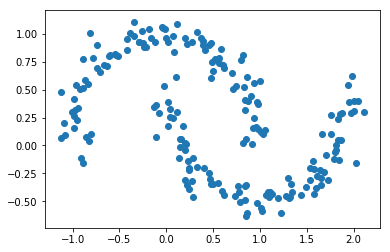

In [4]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=200, noise=0.1)

plt.scatter(X[:, 0], X[:, 1])
plt.show()

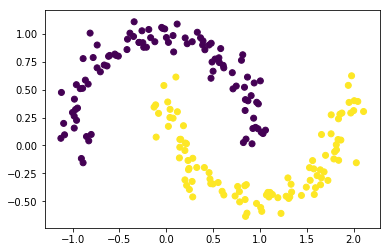

In [8]:
labels = MyDBSCAN(X, eps=0.21, MinPts=4)

plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.show()